
# Семинар 7 (part2): Metric learning + GradCam for embeddings

В рамках данного семинара рассмотрим подробно модуль lightning.pytorch. Обучим сеть, решающую задачу metric learning на датасете СARS196, https://paperswithcode.com/sota/metric-learning-on-cars196

Данные можно найти по ссылкам:
* meta : https://drive.google.com/file/d/1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7/view?usp=sharing
* data : https://drive.google.com/file/d/1l9EnYMC-xGX706SY1kN8RceMmFViASfx/view?usp=sharing

А также рассмотрим библиотеку GradCam для интерпретации работы моделей компьютерного зрения:
repo - https://github.com/jacobgil/pytorch-grad-cam

paper - https://arxiv.org/abs/1610.02391

## постановка задачи

Хотим обучить модель, которая могла бы переводить изображения в такое латентное простраство, где:
1. Изображения из одного класса (или похожие) находились бы близко друг к другу
2. Расстояния до разных изображений должны быть больше, чем до одинаковых

В ходе семинара ответим на следующие вопросы:
1. Что такое похожие изображения?
2. Как обучить модели, чтобы решить данную задачу?
3. Как искать изображения?

![main problem](images/main_problem.png)

In [36]:
!pip install pytorch_metric_learning
!pip install faiss-cpu

Looking in indexes: http://mirror.i/PyPI/simple

[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Looking in indexes: http://mirror.i/PyPI/simple

[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
device = 'cuda'

In [2]:
import scipy.io
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [3]:
ADD_PATH = './cars_train'

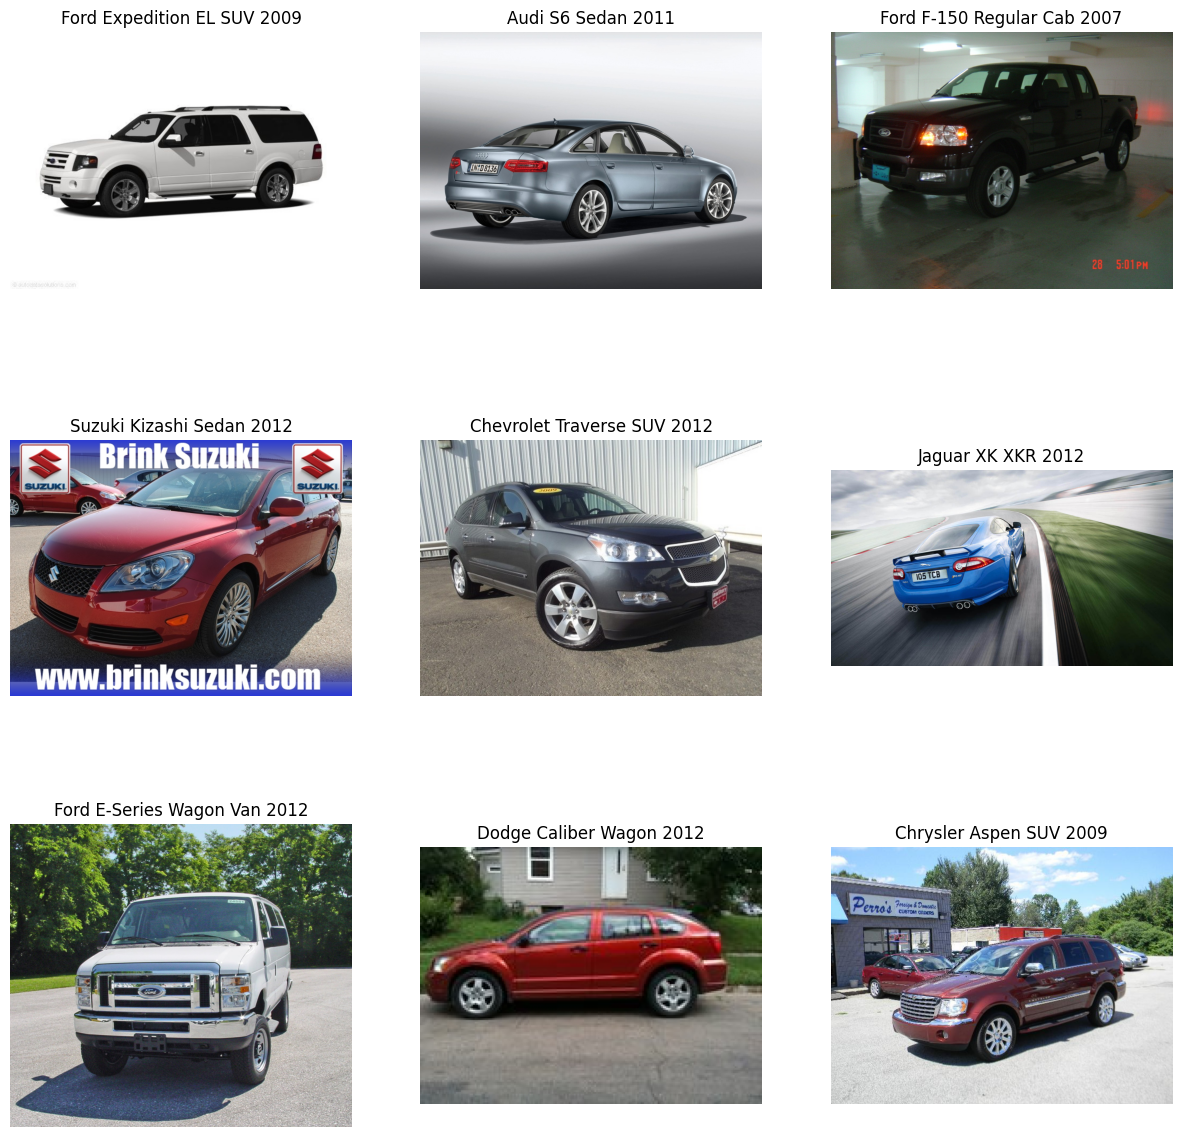

In [4]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

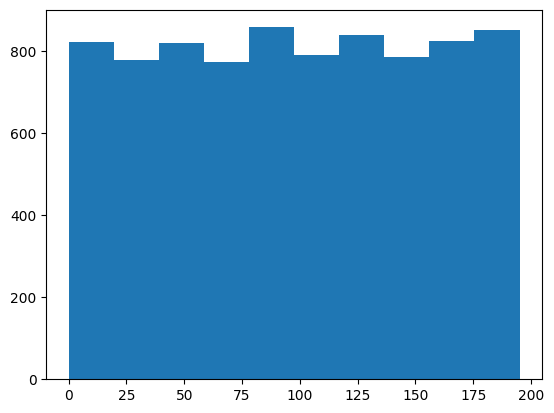

In [5]:
plt.hist(fname_to_class.values())
plt.show()

In [6]:
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

val_transforms =  torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms
        
    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

In [7]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, val_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)


In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

## Center loss
Давайте посмотрим на center loss
Напомню идею:


<img style="float: left;" src="images/center_loss_idea.png" width="60%" height="50%">
По сути мы используем два лосса:
 - дискриминационный (softmax), чтобы обеспечить разделяемость
 - стягивающий для компактности (center loss)


<img style="float: left;" src="images/center_loss_arch.png"  width="60%" height="50%">

In [9]:
import torch
import torch.nn as nn

class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, device='cpu'):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))


    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        self.centers = self.centers.to(device)
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        classes = classes.to(device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

## Arcface

Перейдем к Arcface.
Основная идея A-Softmax лоссов - оперировать на единичной окружности, где за разделимость
отвечает угол между векторами (весами линейного слоя) классов.


<img style="float: left;" src="images/arcface_idea.png" width="70%" height="60%">




Для этого мы усложняем задачу модели для элементов одного класса, занижая скор по
формуле.

<img style="float: left;" src="images/arcface_reduce.png" width="70%" height="60%">
<img style="float: left;" src="images/arcface_formula.png" width="70%" height="60%">

In [10]:
from pytorch_metric_learning import losses
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from torchvision.models import resnet50

class CarEmbedder(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size):
        super().__init__()
        self.learning_rate = learning_rate
        
        self.model = resnet50()
        
        #Because no network
        model_weights = 'resnet50-0676ba61.pth'
        state_dict = torch.load(model_weights)
        self.model.load_state_dict(state_dict)
        # Else
        # self.model = resnet50(pretrained=True)
        
        self.model.fc = torch.nn.Sequential(
                            torch.nn.Linear(in_features=2048, out_features=emb_size))
        
        """
        ArcFace
        """
        
        self.arc_face_loss = losses.ArcFaceLoss(len(class_dict), emb_size, margin=28.6, scale=64)
        
        
        """
        CE + CenterLoss
        """
        # self.classifier_head = torch.nn.Sequential(
        #                     torch.nn.ReLU(),
        #                     torch.nn.Linear(in_features=emb_size, out_features=len(class_dict)))
        # self.classif_loss = torch.nn.CrossEntropyLoss()
        # self.center_loss = CenterLoss(len(class_dict), emb_size, device)

        # self.alpha = 0.4

        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)
        
        """
        ArcFace
        """
        
        final_loss = self.arc_face_loss(preds, labels)
        
        """
        CE + CenterLoss
        """
        
        # center_loss = self.center_loss(preds, labels)
        # preds = self.classifier_head(preds)
        # classif_loss = self.classif_loss(preds, labels)
        # final_loss = center_loss * self.alpha + classif_loss
        
        self.log("train_loss", final_loss, sync_dist=True)
        return final_loss
    
    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)
        
        """
        ArcFace
        """
        
        final_loss = self.arc_face_loss(preds, labels)
        
        """
        CE + CenterLoss
        """
#         center_loss = self.center_loss(preds, labels)
#         preds = self.classifier_head(preds)
#         classif_loss = self.classif_loss(preds, labels)
#         final_loss = center_loss * self.alpha + classif_loss
        
        self.log("validation_loss", final_loss, sync_dist=True)
        
    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images) 
        else:
            preds = self.model(images.unsqueeze(0))
        return preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

In [11]:
# model
pl_model = CarEmbedder(id_to_car, 3e-4, 512)
checkpoint_callback = ModelCheckpoint(monitor='validation_loss',mode='min',  save_top_k=3)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(
    max_epochs=40, 
    accelerator=device, 
    devices=4, 
    callbacks=[checkpoint_callback, early_stopping, lr_monitor])

/tmp/ipykernel_52798/964130429.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_weights)
GPU available: True (cuda), used: True
TPU availab

In [12]:
trainer.fit(model=pl_model, train_dataloaders=train_loader, 
            val_dataloaders=valid_loader)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type        | Params | Mode 
------------------------------------------------------
0 | model         | ResNet      | 24.6 M | train
1 | arc_face_loss | ArcFaceLoss | 100 K  | train
------------------------------------------------------
24.7 M    Trainable params
0         Non-t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/jupyter/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/jupyter/lib/python3.8/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [13]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/opt/jupyter/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:215: Using `DistributedSampler` with the dataloaders. During `trainer.validate()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Other

Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     validation_loss        22.504499435424805
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'validation_loss': 22.504499435424805}]

# Поиск похожих
Поиск наиболее похожих элементов (документов, товаров, пользователей...) согласно заданной метрике близости или расстояния (Жаккард, Косинус, Евклид,...)

Классические примеры: k-ближайших соседей, ранжирование (рексистемы,чат-боты, распознавание лиц, ), дедупликация документов

Расстояние – переводит пару элементов некоторого пространства в вещественное число
Должно удовлетворять условиям:
1. Расстояние неотрицательно
2. Расстояние равно нулю только тогда, когда
совпадают элементы
3. Расстояние симметрично  
Примеры: Jaccard, Euclidian, Cosine

<img src="images/vectors.png"  width="50%" height="30%">



## Facebook AI research Similarity Search (FAISS)
FAISS состоит из трех основных частей
1. Asymmetric distance computation (ADC)
2. Inverted file (IVF)
3. Product quantization (PQ)

link - https://github.com/facebookresearch/faiss

### FAISS. ADC
1. Воспользуемся идеей корзинок и разделим наше пространство на кластеры с помощью K-Means
2. Для репрезентации корзины возьмем вектор центрального элемента
3. При запросе находим ближайший центр
4. Достаем элементы кластера через IVF
<img src="images/vectors2.png"  width="50%" height="30%">

### FAISS IVF

Для центров кластера просто храним список элементов в нем
<img src="images/vectors3.png"  width="50%" height="30%">
### FAISS: PQ
1. Вычитаем элементы центроида из вектора
2. Делим полученный вектор на корзинки
3. Каждую из частей кластеризуем и заменяем индексом центра
<img src="images/vectors4.png"  width="50%" height="30%">

https://mccormickml.com/2017/10/13/product-quantizer-tutorial-part-1/

### FAISS: Поиск
1. При запросе находим несколько ближайших центров кластеров
2. Достаем элементы кластера через IVF
3. Остаток вектора от запроса до центра
кластера кодируется через PQ
4. Расстояние от запроса до элемента
определяется, как сумма расстояний от центров кластеров между всеми корзинками
5. Достаем ближайших
<img src="images/vectors5.png"  width="50%" height="30%">

Два основных параметра, которыми мы рулим:

- кол-во центройдов. Определяет на сколько частей мы бьем наше пространство
* если их мало, то будет долгий поиск, т.к. почти фулл скан нужно сделать
- чем больше центройдов, тем дольше строить индекс
- nprobes - кол-во проб (т.е. поисков по центройдам), при =1 берем только самый ближайший, но тогда будет низкая точность AKNN
 * линейно зависит время поиска
 
 Достойны упоминания: annoy, HNSW

In [14]:
import tqdm
import numpy as np
pl_model.eval()
pl_model.to(device)
np.float32

numpy.float32

In [15]:
def get_embeds(model, loader):
    embeddings = np.empty((1,512))
    labels = np.empty((1))
    for batch in tqdm.tqdm_notebook(loader):
        imgs = batch['image']
        label = batch['label']
        with torch.no_grad():
            preds = model(imgs.to(device))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label.numpy()])
    return embeddings[1:].astype(np.float32), labels[1:]

In [16]:
train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, valid_loader)

/tmp/ipykernel_52798/3342089651.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm.tqdm_notebook(loader):


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [18]:
train_emb.shape

(6464, 512)

In [17]:
import faiss                   # make faiss available
index = faiss.IndexFlatL2(512)   # build the index
print(index.is_trained)
index.add(train_emb)                  # add vectors to the index
print(index.ntotal)

k = 4                          # we want to see 4 nearest neighbors
D, I = index.search(train_emb[:5], k) # sanity check
print(I)
print(D)
D, I = index.search(val_emb, k)     # actual search
print(I[:5])                   # neighbors of the 5 first queries
print(I[-5:]) 

True
6464
[[   0 1079 1966 6410]
 [   1 2771  352  899]
 [   2 2750  339 4974]
 [   3 5595 3763  431]
 [   4  204 5519 5310]]
[[ 0.        16.299795  20.856869  24.377514 ]
 [ 0.        13.462233  13.7788315 14.633997 ]
 [ 0.         9.576044  10.146682  11.211975 ]
 [ 0.         9.260511  10.512802  11.213654 ]
 [ 0.        13.400923  13.586712  13.955353 ]]
[[5795 3245  194 1968]
 [ 615 5795 4480 5113]
 [1659 3764 2785 1641]
 [5336 5795 3632 2903]
 [ 483 5795 1206 2903]]
[[2903 5795 2558 2449]
 [ 213 4177 4357  940]
 [4489 2058 5733 5039]
 [3973 4544 5958 3656]
 [5502 3277 2655 4990]]


In [19]:
Distances, Indexes = index.search(val_emb, 1)

In [20]:
Indexes

array([[5795],
       [ 615],
       [1659],
       ...,
       [4489],
       [3973],
       [5502]])

In [22]:
print(f'Precision/Recall @ 1 : {np.sum((val_labels == train_labels[Indexes.flatten()]))/val_labels.shape[0]}')

Precision/Recall @ 1 : 0.6531614487415592


# GradCam with embeds

In [21]:
from PIL import Image
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

transform_to_show = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(), 
                        torchvision.transforms.Resize(
                            size=(224, 224)
                        ),
                        torchvision.transforms.ToTensor()
                        ])

def get_image_from_path(path):
    """A function that gets a path to an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    orig_im = np.array(Image.open(path).convert('RGB'))
    rgb_im = np.array(transform_to_show(orig_im).permute(1,2,0))
    transformed_im = val_transforms(orig_im).unsqueeze(0).to(device)
    orig_im = cv2.resize(orig_im, (512, 512))

    return orig_im, rgb_im, transformed_im

In [22]:
car_img, car_img_float, car_tensor = get_image_from_path("images/car.png")
cloud_img, cloud_img_float, cloud_tensor = get_image_from_path("images/cloud.png")
car_concept_features = pl_model(car_tensor)[0, :]
cloud_concept_features = pl_model(cloud_tensor)[0, :]

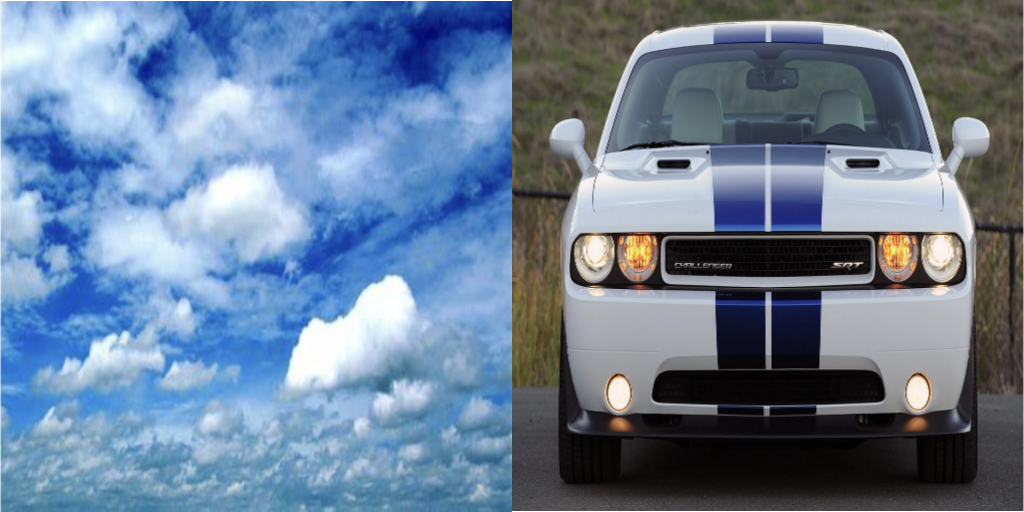

In [23]:
Image.fromarray(np.hstack((cloud_img, car_img)))

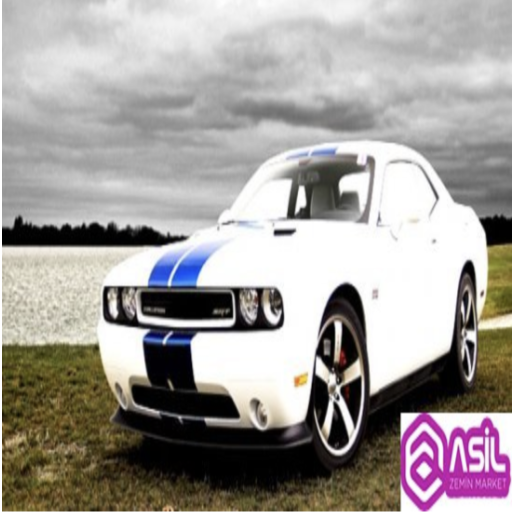

In [24]:
image, image_float, input_tensor = get_image_from_path("images/car2.png")
Image.fromarray(image)

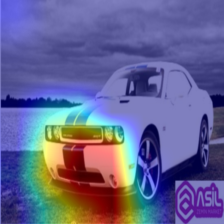

In [25]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
target_layers = [pl_model.model.layer4[-1]]
car_targets = [SimilarityToConceptTarget(car_concept_features)]
cloud_targets = [SimilarityToConceptTarget(cloud_concept_features)]

# Where is the car in the image
with GradCAM(model=pl_model.model,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

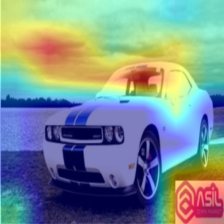

In [26]:
# Where is the cloud in the image
with GradCAM(model=pl_model.model,
             target_layers=target_layers) as cam:
    cloud_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=cloud_targets)[0, :]
cloud_cam_image = show_cam_on_image(image_float, cloud_grayscale_cam, use_rgb=True)
Image.fromarray(cloud_cam_image)

In [27]:
class DifferenceFromConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return 1 - cos(model_output, self.features)

not_car_targets = [DifferenceFromConceptTarget(car_concept_features)]
not_cloud_targets = [DifferenceFromConceptTarget(cloud_concept_features)]

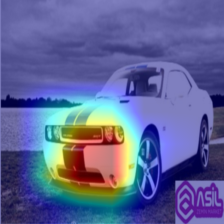

In [28]:
# Where is the cloud not in the image?
with GradCAM(model=pl_model.model,
             target_layers=target_layers) as cam:
    not_cloud_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=not_cloud_targets)[0, :]
cam_image = show_cam_on_image(image_float, not_cloud_grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

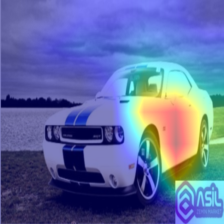

In [29]:
# Where is the car not in the image?
with GradCAM(model=pl_model.model,
             target_layers=target_layers) as cam:
    not_car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=not_car_targets)[0, :]
cam_image = show_cam_on_image(image_float, not_car_grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

In [30]:
car_embed = car_concept_features

In [31]:
cloud_embed = cloud_concept_features

In [33]:
input_embed = pl_model(input_tensor)[0, :]

In [34]:
car_embed.shape, cloud_embed.shape, input_embed.shape

(torch.Size([512]), torch.Size([512]), torch.Size([512]))

In [37]:
cos = torch.nn.CosineSimilarity(dim=0)
cos(cloud_embed, input_embed)

tensor(-0.1084, device='cuda:0', grad_fn=<SumBackward1>)

In [36]:
cos = torch.nn.CosineSimilarity(dim=0)
cos(input_embed, car_embed)

tensor(0.9449, device='cuda:0', grad_fn=<SumBackward1>)